# Importar Bibliotecas

In [1]:
import pandas as pd
import json
import numpy as np
import random
import datetime
import os
from scipy import stats
from math import radians, cos, sin, asin, sqrt
import statsmodels.api as sm
import pickle
import geopandas as gpd
from shapely.geometry import Point,Polygon
import pyproj

import re
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
# https://plotly.com/python/3d-scatter-plots/

from bokeh.plotting import figure, show, gmap
from bokeh.tile_providers import get_provider,STAMEN_TERRAIN, OSM # https://docs.bokeh.org/en/latest/docs/reference/tile_providers.html
from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, LabelSet,LogColorMapper,
                          GeoJSONDataSource, HoverTool, GMapOptions,
                          LinearColorMapper, Slider, DateRangeSlider, LogTicker)
from bokeh.io import output_notebook, reset_output, export_png
from bokeh.layouts import column, row, widgetbox
from bokeh.transform import linear_cmap
from bokeh.palettes import Turbo256,brewer
from bokeh.models.widgets import RangeSlider

import folium
from folium.plugins import HeatMap

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import sklearn
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

import lazypredict
from lazypredict.Supervised import LazyClassifier

lazypredict.Supervised.CLASSIFIERS = [('DummyClassifier', sklearn.dummy.DummyClassifier),
                                      ('GaussianNB', sklearn.naive_bayes.GaussianNB),
                                      ('BernoulliNB', sklearn.naive_bayes.BernoulliNB),
                                      # ('CategoricalNB', sklearn.naive_bayes.CategoricalNB),
                                      ('DecisionTreeClassifier', sklearn.tree._classes.DecisionTreeClassifier),
                                      ('RandomForestClassifier', sklearn.ensemble._forest.RandomForestClassifier),
                                      # ('KNeighborsClassifier',sklearn.neighbors._classification.KNeighborsClassifier),
                                      ('LogisticRegression', sklearn.linear_model._logistic.LogisticRegression),
                                      # ('SGDClassifier', sklearn.linear_model._stochastic_gradient.SGDClassifier),
                                      # ('SVC', sklearn.svm._classes.SVC), #leva muito tempo
                                     ]

sns.set_style("darkgrid")

bold   = "\033[1m"
unbold = "\033[0m"

import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:93% !important; }</style>"))

RANDOM_STATE = 123
DF_TRATADO_PARQUET_FOLDER = r"./Arquivos SSP\bancos_auxiliares\bkp/"
EXPORT_CHARTS_TCC         = r'./Graficos e Prints/'
BANCOS_AUXILIARES         = r'./Arquivos SSP\bancos_auxiliares/'
VERBOSE                   = True

# Funções

## tratar_acentos

In [2]:
def tratar_acentos(string):
    '''
        Padronizar strings: Sem acentos, maiúsculo
    '''
    if isinstance(string,str):
        string = string.lower()

        acentos_dict = {'a':['á','à','â','ã','ä'],
                        'e':['é','è','ê','ë'],
                        'i':['í','ì','î','ï'],
                        'o':['ó','ò','ô','õ','ö'],
                        'u':['ú','ù','û','ü'],
                        'c':['ç'],
                        'd ':["d'"],# 'APARECIDA D OESTE', "APARECIDA D'OESTE",
                       }

        for key, value_list in acentos_dict.items():
            for acento in value_list:
                string = string.strip().replace(acento,key)

        return string.upper()
    else:
        return string

## Função Plot folium_heatmap

In [18]:
def folium_heatmap(df, sample_size = 20000):
    
    df_folium = pd.DataFrame({'Lat':df['LATITUDE'],'Long':df['LONGITUDE'],'Count':sm.add_constant(df['NUMERO'])['const']})
    
    df_folium = df_folium.sample(sample_size).dropna()
    
    df_folium['weight'] = df_folium['Count'] / df_folium['Count'].abs().max()
    
    def generateBaseMap(loc, zoom=7.45, tiles='OpenStreetMap', crs='ESPG2263'):
        return folium.Map(location=loc,
                       control_scale=True, 
                       zoom_start=zoom,
                       tiles=tiles)
      
    base_map = generateBaseMap([-23, -46] )
    
    map_values1 = df_folium[['Lat','Long','weight']]
    
    data = map_values1.values.tolist()
               
    hm = HeatMap(data,gradient={0.1: 'blue', 0.3: 'lime', 0.5: 'yellow', 0.7: 'orange', 1: 'red'}, 
                    min_opacity=0.6, 
                    max_opacity=0.9, 
                    radius=30,
                    use_local_extrema=True)#.add_to(base_map)
    
    folium.Marker(
        [-23.5489, -46.6388], popup="<b>São Paulo</b>", tooltip='Clique aqui'
    ).add_to(base_map)
    
    base_map.add_child(hm)
    base_map.save(EXPORT_CHARTS_TCC +'heatmapFolium.html')
    
    display(base_map)

## Função de Plot Bokeh

In [3]:
def plot_bokeh_lat_lon(df,TOOLTIPS,lon_col,lat_col,size_col=8,alpha=0.6,fill_color='cyan'):
    
    df_plot = df.copy()
    
    #FUNCTION TO CONVERT GCS WGS84 TO WEB MERCATOR
    def wgs84_web_mercator_point(lon,lat):
        
        k = 6378137
        x= lon * (k * np.pi/180.0)
        y= np.log(np.tan((90 + lat) * np.pi/360.0)) * k
        return x,y

    #DATA FRAME
    def wgs84_to_web_mercator(df1, lon, lat):
        
        df = df1.copy()
        
        k = 6378137
        df[lon+"_mercator"] = df[lon] * (k * np.pi/180.0)
        df[lat+"_mercator"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
        return df
    
    
    df_plot = wgs84_to_web_mercator(df_plot, lon = lon_col, lat = lat_col)

    lon_min,lat_min = df_plot[lon_col].min() , df_plot[lat_col].min()
    lon_max,lat_max = df_plot[lon_col].max() , df_plot[lat_col].max()
    
    #COORDINATE CONVERSION
    xy_min = wgs84_web_mercator_point(lon_min,lat_min)
    xy_max = wgs84_web_mercator_point(lon_max,lat_max)
    
    
    output_notebook()
    
    # TOOLTIPS = [
        # ("CIDADE: ", "@Cidade"),
        # ('Eventos Criminosos','@Eventos_Criminosos'),
        # ('Populacao', "@Populacao"),
        # ("Indice de eventos por 1000 hab", "@Eventos_Criminosos_1000_hab"),
    # ]
    
    #Create random HEX Color
    r = lambda: random.randint(0,255)
    # print('#%02X%02X%02X' % (r(),r(),r()))
    
    if fill_color in df_plot.columns:
        column_categories_colors = df_plot[fill_color].groupby(df_plot[fill_color]).apply(lambda x: '#%02X%02X%02X' % (r(),r(),r()))
        df_plot = df_plot.join(column_categories_colors,on=fill_color,rsuffix='_r')
        fill_color = fill_color + '_r'
    
    if isinstance(size_col,str):
        try:
            # configure sizes:
            df_plot['circle_sizes'] = round(stats.zscore(df_plot[size_col])+4,2)*4
        except:
            df_plot['circle_sizes'] = size_col            
    else:
        df_plot['circle_sizes'] = size_col
    
    
    #FIGURE SETTING
    x_range,y_range = ([xy_min[0], xy_max[0]] , [xy_min[1], xy_max[1]])
    
    p               = figure(x_range = x_range, y_range = y_range,
                             x_axis_type='mercator',y_axis_type='mercator',
                             sizing_mode='scale_width',
                             plot_height=300,
                             plot_width = 800,
                             tooltips = TOOLTIPS)
    
    #PLOT BASEMAP AND AIRPLANE POINTS
    flight_source = ColumnDataSource(df_plot)
    tile_prov=get_provider(OSM)
    p.add_tile(tile_prov,level='image')
    
    palette = Turbo256
    p.circle(lon_col+"_mercator",
             lat_col+"_mercator",
             source=flight_source,
             hover_color='yellow',
             size='circle_sizes',
             fill_alpha=alpha,
             line_alpha=alpha,
             fill_color=fill_color)
    
    p.xaxis.axis_label = 'longitude'
    p.yaxis.axis_label = 'latitude'
    
    show(p)

## Função para criar grade no plot geográfico para cidades

In [4]:
def criar_grade_cidades(canto_inferior_esquerdo,canto_superior_esquerdo,canto_superior_direito,canto_inferior_direito):
    
    """
    Esta função cria uma grade com quadrados de 5km² a partir do mapa do município desejado
    
    <args>:
        Coordenadas do envelope do mapa da cidade (cantos extremos, nomeados de forma autoexplicativa)
    """
    
    def haversine(lon1, lat1, lon2, lat2):
        """
        Calcular a distância entre dois pontos na superfície do planeta Terra (input em graus)
        """
        # converte graus para radianos
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
        # formula haversine  
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a)) 
        r = 6371 # Valor do raio da Terra em quilômetros
        return c * r

    distancia_longitudinal = haversine(lon1=canto_superior_esquerdo[0], lat1=canto_superior_esquerdo[1], lon2=canto_superior_direito[0], lat2=canto_superior_direito[1])
    distancia_vertical     = haversine(lon1=canto_superior_esquerdo[0], lat1=canto_superior_esquerdo[1], lon2=canto_inferior_esquerdo[0], lat2=canto_inferior_esquerdo[1])
    
    TAMANHO_QUADRADO = 5 # km²
    TAMANHO_QUADRADO = TAMANHO_QUADRADO**(1/2)
    
    n_quadrados_horizontais, n_quadrados_verticais = round(distancia_longitudinal/TAMANHO_QUADRADO),round(distancia_vertical/TAMANHO_QUADRADO)
    
    print("Total de quadrados:", n_quadrados_horizontais * n_quadrados_verticais)
    
    comprimento_x_long_quadrados = abs(canto_superior_esquerdo[0] - canto_superior_direito[0])/n_quadrados_horizontais
    comprimento_y_lat_quadrados = abs(canto_superior_esquerdo[1] - canto_inferior_esquerdo[1])/n_quadrados_verticais
    
    # Usando o "canto_inferior_esquerdo" como start:
    
    coords_quadrados_list = []
    
    for j in range(n_quadrados_verticais):
        
        c_inf_esq = (canto_inferior_esquerdo[0], canto_inferior_esquerdo[1]+ j*comprimento_y_lat_quadrados)
        
        for i in range(n_quadrados_horizontais):
            
            coord_quadrado = (
                (c_inf_esq[0]                               , c_inf_esq[1]                            ), # canto_inferior_esquerdo
                (c_inf_esq[0]                               , c_inf_esq[1]+comprimento_y_lat_quadrados), # canto_superior_esquerdo
                (c_inf_esq[0]+ comprimento_x_long_quadrados , c_inf_esq[1]+comprimento_y_lat_quadrados), # canto_superior_direito
                (c_inf_esq[0]+ comprimento_x_long_quadrados , c_inf_esq[1]                            ), # canto_inferior_direito
                            )
            coords_quadrados_list.append(coord_quadrado)
            c_inf_esq = coord_quadrado[3]
    
    return coords_quadrados_list

## Função para mapear quantidade de eventos dentro de cada elemento da malha

In [5]:
def mapear_malha_qty(df, filename = None):
    
    '''
        df: dataframe que contenha a coluna "LatLonPoints" (Latitude e Longitude transformados em instâncias de Point)
    '''
    
    try:
        if filename is None:
            square_qty_map = pd.read_parquet(BANCOS_AUXILIARES + 'square_qty_map.parquet')['qty']
        else:
            square_qty_map = pd.read_parquet(BANCOS_AUXILIARES + filename)['qty']

    except:
        print('>>> Iniciando processo de criação de dicionário (Pode levar mais de 30 minutos...)')
        square_qty_map = {}
        for num,square in enumerate(coords_quadrados_list):
            if num%100==0:
                print('>>> QUADRADO: ',num)
            square_qty_map[num] = df['LatLonPoints'].apply(lambda point: point.covered_by(Polygon(square))).sum()
    
    square_qty_map = pd.Series(square_qty_map).to_frame(name='qty')
    if filename is None:
        square_qty_map.to_parquet(BANCOS_AUXILIARES + 'square_qty_map.parquet')
    else:
        square_qty_map.to_parquet(BANCOS_AUXILIARES + filename)
        
    return square_qty_map

## Função para plotar a malha da cidade (com densidade de eventos se o df possuir a coluna "LatLonPoints")

In [6]:
def plotar_malha_cidade(df,shapefile_df,filename=None, CIDADE='SAO PAULO',plot_title='Malha 5km²'):
    
    # Input GeoJSON
    df_shapefile_plot = shapefile_df.loc[shapefile_df['NM_MUN']==CIDADE].copy()
    CIDADE_AREA = df_shapefile_plot['geometry'].values[0]
    
    geosource = GeoJSONDataSource(geojson = df_shapefile_plot.to_json())
    
    # Create figure object
    p = figure(title = f'{CIDADE} - {plot_title}', 
               plot_height = 600 ,
               plot_width = 450, 
               tools = 'pan, wheel_zoom, box_zoom, reset')
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    
    # Add patch renderer to figure.
    municipios = p.patches('xs','ys', source = geosource,
                       fill_color = None,
                       line_color = 'darkgray', 
                       line_width = 1)
    
    # GRID em volta da cidade
    longs = (CIDADE_AREA.bounds[0],CIDADE_AREA.bounds[2])
    lats  = (CIDADE_AREA.bounds[1],CIDADE_AREA.bounds[3])
    
    canto_inferior_esquerdo = (min(longs),min(lats))
    canto_superior_esquerdo = (min(longs),max(lats))
    canto_superior_direito  = (max(longs),max(lats))
    canto_inferior_direito  = (max(longs),min(lats))
    
    coords_quadrados_list = criar_grade_cidades(canto_inferior_esquerdo,canto_superior_esquerdo,canto_superior_direito,canto_inferior_direito)
    
    if ("LatLonPoints" in df.columns):
        square_qty_map = mapear_malha_qty(df=df, filename=filename)
        alpha_list = list(square_qty_map.values/max(square_qty_map.values))
        fill_color = 'red'
    else:
        alpha_list = [0.3]*len(coords_quadrados_list)
        fill_color = 'gray'
        
    for ind,square in enumerate(coords_quadrados_list):
        p.patches(xs=[[i[0] for i in square]], ys=[[i[1] for i in square]],fill_color=fill_color,fill_alpha=alpha_list[ind],line_alpha=0.3)
    
    coords_macro = (canto_inferior_esquerdo,canto_superior_esquerdo,canto_superior_direito,canto_inferior_direito)
    print(f'A cidade de {CIDADE} está contida na forma: ',CIDADE_AREA.covered_by(Polygon(coords_macro)))
    
    # Create hover tool
    p.add_tools(HoverTool(renderers = [municipios],
                          tooltips = [('Municipio','@NM_MUN'),
                                    ('Area_KM2','@AREA_KM2')]))
    show(p)
    
    return coords_quadrados_list
    
    # save the results to a file
    # export_png(p, filename=EXPORT_CHARTS_TCC+"Bokeh.png")
    

# Importar dados

## Arquivo com formato dos municipios de São Paulo

In [7]:
shp_path = './SP_Municipios_shapefiles/SP_Municipios_2022.shp'
shapefile_SP_df = gpd.read_file(shp_path)
shapefile_SP_df['NM_MUN'] = shapefile_SP_df['NM_MUN'].apply(tratar_acentos)
shapefile_SP_df.sample(10)

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry
461,3541109,PRESIDENTE ALVES,SP,286.64,"POLYGON ((-49.45179 -22.06552, -49.45173 -22.0..."
503,3544905,SALES OLIVEIRA,SP,305.78,"POLYGON ((-47.79180 -20.74925, -47.78830 -20.7..."
572,3551306,SEBASTIANOPOLIS DO SUL,SP,167.85,"POLYGON ((-49.95392 -20.66677, -49.95493 -20.6..."
539,3548203,SANTO ANTONIO DO PINHAL,SP,133.01,"POLYGON ((-45.63085 -22.82764, -45.63082 -22.8..."
341,3530409,MIRASSOLANDIA,SP,166.12,"POLYGON ((-49.48643 -20.50139, -49.48628 -20.5..."
179,3515657,FERNAO,SP,100.50,"POLYGON ((-49.53521 -22.32074, -49.53275 -22.3..."
196,3517208,GUAICARA,SP,277.15,"POLYGON ((-49.77319 -21.63195, -49.77326 -21.6..."
467,3541653,QUADRA,SP,205.67,"POLYGON ((-48.08074 -23.33332, -48.08092 -23.3..."
91,3508009,BURI,SP,1196.46,"POLYGON ((-48.66437 -23.89717, -48.66537 -23.8..."
262,3522901,ITAPUI,SP,140.02,"POLYGON ((-48.72705 -22.31678, -48.72793 -22.3..."


## Importar Dataframe tratado

In [8]:
df_crimes = pd.read_parquet(DF_TRATADO_PARQUET_FOLDER + 'df_crimes_tratado.parquet')

try:
    df_SP = pd.read_parquet(BANCOS_AUXILIARES + 'df_SP_Square_ID.parquet')
    df_SP = df_SP.assign(LatLonPoints=df_SP[['LATITUDE','LONGITUDE']].apply(lambda row: Point(row['LONGITUDE'],row['LATITUDE']),axis=1))

except:
    df_SP = df_crimes[df_crimes['CIDADE']=='SAO PAULO']
    df_SP = df_SP.assign(LatLonPoints=df_SP[['LATITUDE','LONGITUDE']].apply(lambda row: Point(row['LONGITUDE'],row['LATITUDE']),axis=1))

df_SP['ANO'] = df_SP['DATAOCORRENCIA'].apply(lambda x: x.year)

df_SP.head()

,arquivo_de_origem,NATUREZA_APURADA,CIDADE,BAIRRO,LOGRADOURO,NUMERO,DESCRICAOLOCAL,LATITUDE,LONGITUDE,DATAOCORRENCIA,...,PERIDOOCORRENCIA,SEXO,IDADE,HORA_PERIODO,DIA_SEMANA,FERIADO,Descricao_FERIADO,Square_ID,LatLonPoints,ANO
0,Feminicidio_2015_2022.parquet,EVENTO COM PERDA DE VIDA,SAO PAULO,None,RUA ARATIMBO,98.00,VIA PUBLICA,-23.65,-46.60,2018-02-11,...,EM HORA INCERTA,FEMININO,23.00,MADRUGADA,DOMINGO,False,,367.00,POINT (-46.597479296 -23.649500996125),2018
1,Feminicidio_2015_2022.parquet,EVENTO COM PERDA DE VIDA,SAO PAULO,None,AVENIDA ARQUITETO VILANOVA ARTIGAS,62.00,VIA PUBLICA,-23.61,-46.50,2018-02-10,...,EM HORA INCERTA,FEMININO,31.00,TARDE,SABADO,False,,413.00,POINT (-46.5018218800652 -23.6142769734717),2018
6,Feminicidio_2015_2022.parquet,EVENTO COM PERDA DE VIDA,SAO PAULO,None,AVENIDA DUQUE DE CAXIAS,400.00,VIA PUBLICA,-23.54,-46.65,2018-05-27,...,EM HORA INCERTA,FEMININO,54.00,MADRUGADA,DOMINGO,False,,491.00,POINT (-46.6455102455416 -23.538568316625),2018
9,Feminicidio_2015_2022.parquet,EVENTO COM PERDA DE VIDA,SAO PAULO,None,RUA DOUTOR OVIDIO PIRES DE CAMPOS,333.00,SAUDE,-23.55,-46.67,2018-06-13,...,EM HORA INCERTA,FEMININO,26.00,TARDE,QUARTA-FEIRA,False,,468.00,POINT (-46.673080431 -23.554882092),2018
10,Feminicidio_2015_2022.parquet,EVENTO COM PERDA DE VIDA,SAO PAULO,None,AVENIDA ELISEU DE ALMEIDA,3950.00,VIA PUBLICA,-23.58,-46.73,2018-06-30,...,EM HORA INCERTA,FEMININO,34.00,NOITE,SABADO,False,,424.00,POINT (-46.7284063474019 -23.5847964223184),2018


## Bases de dados auxiliares

https://raw.githubusercontent.com/kelvins/Municipios-Brasileiros/main/csv/municipios.csv
Filtrados para SP

In [9]:
populacao_SP = pd.read_csv(BANCOS_AUXILIARES+"SP_population.txt",
                           sep='\t',header=None).rename({0:'Posicao',1:'Cidade',2:'Populacao'},axis=1)
populacao_SP['Populacao'] = populacao_SP['Populacao'].str.replace('.','').astype(int)
populacao_SP['Cidade'] = populacao_SP['Cidade'].apply(lambda x: tratar_acentos(x))

municipios_geo = pd.read_csv(BANCOS_AUXILIARES+'municipios_geo.csv',index_col='Unnamed: 0') # pd.read_csv('https://raw.githubusercontent.com/kelvins/Municipios-Brasileiros/main/csv/municipios.csv')
municipios_geo['nome'] = municipios_geo['nome'].apply(tratar_acentos)
municipios_geo = municipios_geo.loc[municipios_geo['codigo_uf']==35].reset_index(drop=True)

## Taxa de eventos por cidade

In [10]:
homicidio_rate = df_crimes['CIDADE'].value_counts().reset_index().rename({'index':'Cidade','CIDADE':'Eventos_Criminosos'},axis=1)
homicidio_rate = homicidio_rate.join(populacao_SP.set_index('Cidade')['Populacao'],on='Cidade')
homicidio_rate_valid = homicidio_rate.dropna().reset_index(drop=True)
homicidio_rate_valid['Eventos_Criminosos_1000_hab'] = homicidio_rate_valid['Eventos_Criminosos']*1000 / homicidio_rate_valid['Populacao']
homicidio_rate_valid_geo = homicidio_rate_valid.join(municipios_geo.set_index('nome')[['latitude','longitude']],on='Cidade').dropna().reset_index(drop=True)

shapefile_SP_df = shapefile_SP_df.merge(homicidio_rate_valid,left_on='NM_MUN',right_on='Cidade',how='outer').fillna(0).drop('Cidade',axis=1)

homicidio_rate_valid_geo.head()

,Cidade,Eventos_Criminosos,Populacao,Eventos_Criminosos_1000_hab,latitude,longitude
0,SAO PAULO,303545,12396372.00,24.49,-23.53,-46.64
1,SANTO ANDRE,29176,723889.00,40.30,-23.67,-46.54
2,CAMPINAS,29139,1223237.00,23.82,-22.91,-47.07
3,GUARULHOS,23771,1404694.00,16.92,-23.45,-46.53
4,SAO BERNARDO DO CAMPO,19278,849874.00,22.68,-23.69,-46.56


# Análise Exploratória
## Tipos de dados

In [11]:
df_SP.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303545 entries, 0 to 469369
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   arquivo_de_origem  303545 non-null  object 
 1   NATUREZA_APURADA   303545 non-null  object 
 2   CIDADE             303545 non-null  object 
 3   BAIRRO             265023 non-null  object 
 4   LOGRADOURO         297386 non-null  object 
 5   NUMERO             303036 non-null  float64
 6   DESCRICAOLOCAL     303544 non-null  object 
 7   LATITUDE           303545 non-null  float64
 8   LONGITUDE          303545 non-null  float64
 9   DATAOCORRENCIA     303545 non-null  object 
 10  HORAOCORRENCIA     303545 non-null  object 
 11  PERIDOOCORRENCIA   303545 non-null  object 
 12  SEXO               35697 non-null   object 
 13  IDADE              299748 non-null  float64
 14  HORA_PERIODO       297025 non-null  object 
 15  DIA_SEMANA         303545 non-null  object 
 16  FE

## Gráfico de Barras

- NATUREZA_APURADA
- DESCRICAOLOCAL
- HORA_PERIODO

NATUREZA_APURADA


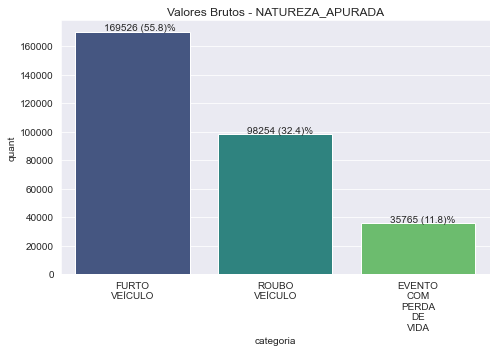

DESCRICAOLOCAL


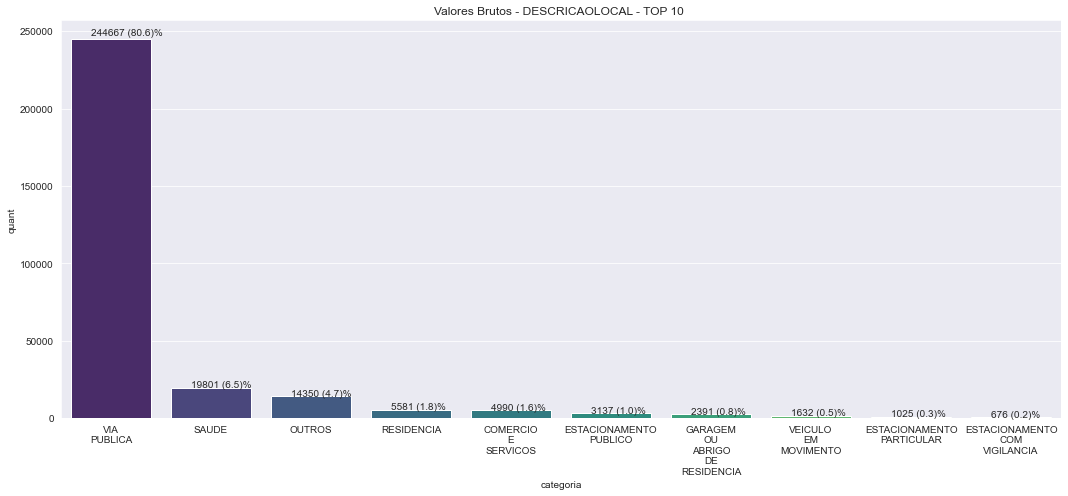

HORA_PERIODO


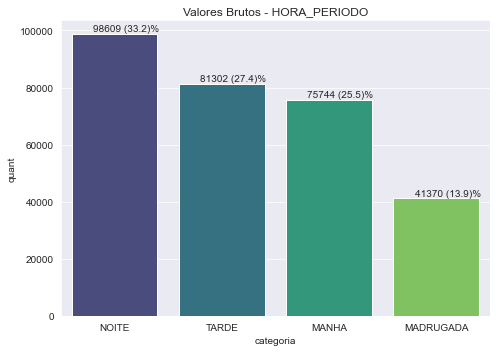

In [12]:
PLOT_TOP_10 = True # False: Plot last 10

for col in ['NATUREZA_APURADA','DESCRICAOLOCAL','HORA_PERIODO']:
    
    print(col)
    
    df_plot_bar = df_SP[col].value_counts().reset_index().rename({'index':'categoria',col:'quant'},axis=1
                                                                                   ).join(df_SP[col].value_counts(normalize=True),on='categoria'
                                                                                         ).rename({col:'porcent'},axis=1)
    
    figheight = 7
    
    top10 = ''
    if len(df_plot_bar['categoria']) > 10:
        figwidth = 15
        
        if PLOT_TOP_10:
            df_plot_bar = df_plot_bar.head(10)
            top10 = ' - TOP 10 '
        else:
            df_plot_bar = df_plot_bar.loc[df_plot_bar['quant']>100].tail(10)
            top10 = ' - LAST 10 '
            
    elif len(df_plot_bar['categoria']) > 5:
        figwidth = 10
    else:
        figwidth = 7
        figheight = 5
    
    
    fig, ax1 = plt.subplots(ncols=1, figsize=(figwidth, figheight))

    
    sns.barplot(data=df_plot_bar,x='categoria',y='quant',ax=ax1,palette='viridis')
    ax1.set_title(f'Valores Brutos - {col}{top10}')
    
    if df_plot_bar['quant'].max()/df_plot_bar['quant'].min() > 1e3:
        
        ax1.set_yscale('log')
        
        max_val_log = [i for i in map(lambda x: x if x > df_plot_bar['quant'].max() else None,[1e4,1e5,1e6,1e7]) if i is not None][0]
        ax1.set_ylim(0,max_val_log)
    
    if df_plot_bar['categoria'].apply(len).max() > 15:
        ax1.set_xticklabels([i.get_text().replace(' ','\n') for i in ax1.get_xticklabels()])
    
    for ind,value in enumerate(df_plot_bar['quant']):
        
        percent = round(df_plot_bar['porcent'].iloc[ind]*100,1)

        ax1.text(x = ind-0.2,
                 y = value + 0.01*value,
                 s = str(value) + f' ({percent})%')

    plt.tight_layout()
    
    plt.savefig(EXPORT_CHARTS_TCC + f'grafico_barras_{col}.png')
    
    plt.show()

# Plots Geográficos

## Formato geral dos dados no mapa

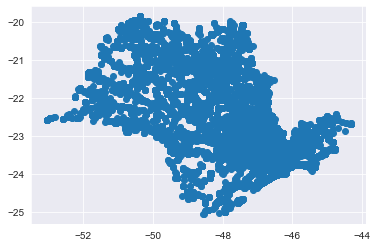

In [13]:
plt.scatter(x=df_crimes['LONGITUDE'], y=df_crimes['LATITUDE'])
plt.show()

## Plot amostra dos dados Bokeh

In [14]:
SAMPLE_SIZE = 200 # -> Quantidade de dados a serem plotados (selecionados aleatoriamente)

tooltips = [
        ("CIDADE: ", "@CIDADE"),
        ('Natureza','@NATUREZA_APURADA'),
]

plot_bokeh_lat_lon(df=df_crimes.sample(SAMPLE_SIZE),TOOLTIPS=tooltips,size_col=10,lon_col='LONGITUDE',lat_col='LATITUDE',alpha=0.7,fill_color='NATUREZA_APURADA')

## Mapa da taxa eventos em cada município

In [15]:
tooltips = [
        ("CIDADE: ", "@Cidade"),
        ('Eventos Criminosos','@Eventos_Criminosos'),
        ('Populacao', "@Populacao"),
        ("Indice de crimes violentos por 1000 hab", "@Eventos_Criminosos_1000_hab"),
]

plot_bokeh_lat_lon(df=homicidio_rate_valid_geo,TOOLTIPS=tooltips,lon_col='longitude',lat_col='latitude',size_col='Eventos_Criminosos_1000_hab')

## Plots para Area/População/Índice de Crimes Violentos

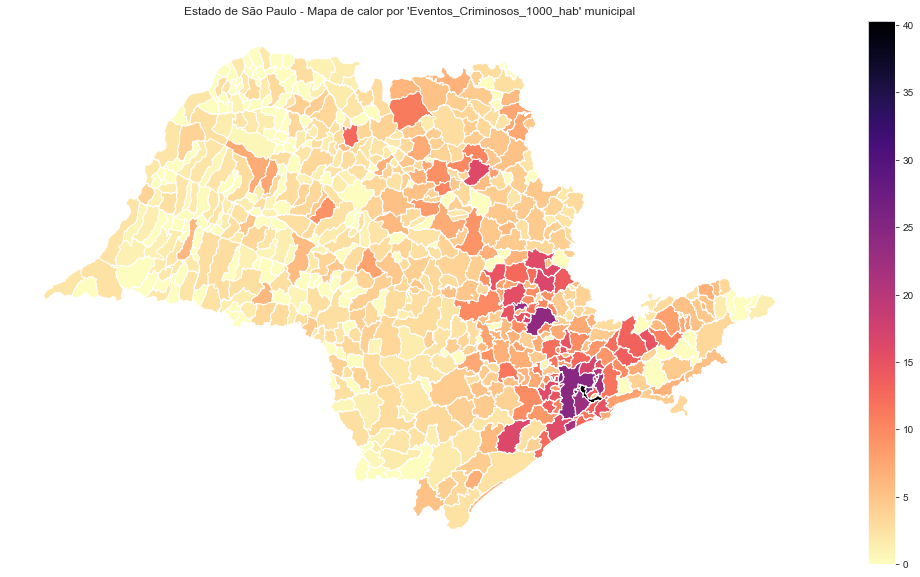

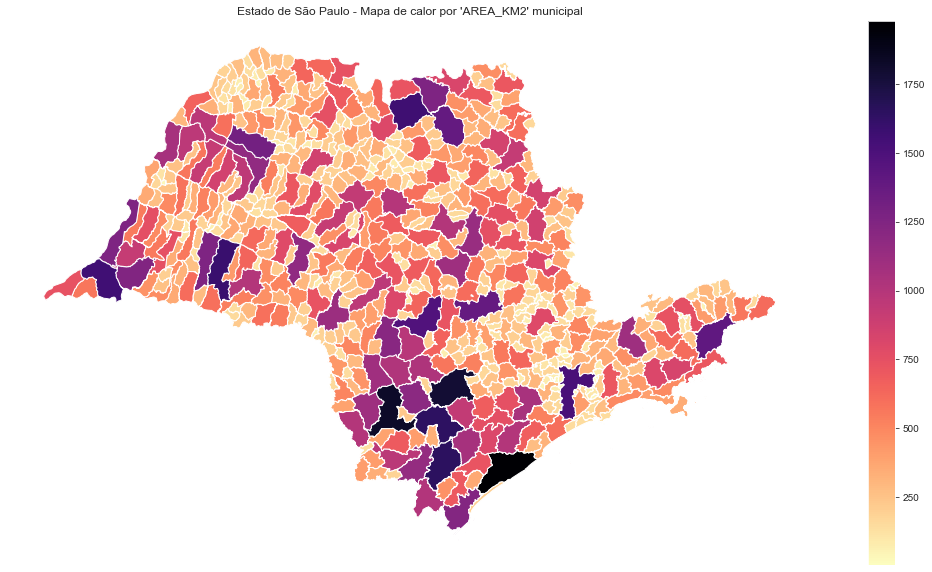

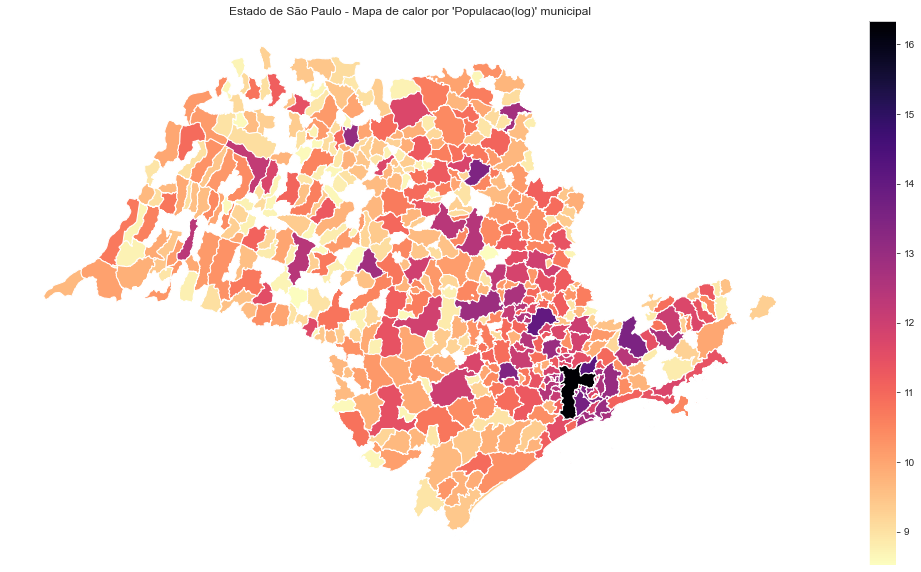

In [16]:
shapefile_SP_df['Populacao(log)'] = shapefile_SP_df.loc[shapefile_SP_df['Populacao']!=0,'Populacao'].apply(np.log).reindex_like(shapefile_SP_df)

for coluna in ['Eventos_Criminosos_1000_hab','AREA_KM2','Populacao(log)']:
    
    ax = shapefile_SP_df.plot(column=coluna, cmap='magma_r', k=5, legend=True)
    plt.title(f"Estado de São Paulo - Mapa de calor por '{coluna}' municipal")
    ax.set_axis_off()
    ax.figure.set_figheight(10)
    ax.figure.set_figwidth(20)
    plt.show()

## GEO-Heatmap Folium

In [17]:
folium_heatmap(df_crimes)

## Plot Geográfico - Localização das TOP10 CIDADES selecionadas (time series)

In [20]:
cidades_selecionadas = round(df_crimes['CIDADE'].value_counts()/10000)>=1
cidades_selecionadas = list(cidades_selecionadas[cidades_selecionadas].index)[:10]

LocalizacaoCidadesSelecionadas = df_crimes.loc[df_crimes['CIDADE'].isin(cidades_selecionadas)].groupby('CIDADE').agg(latitude_media=('LATITUDE','mean'),longitude_media=('LONGITUDE','mean')).reset_index()

base_map_cidades = folium.Map(location=[-23, -46],
                   control_scale=True, 
                   zoom_start=7.45,
                   tiles='OpenStreetMap')

for i,j in LocalizacaoCidadesSelecionadas.iterrows():

    folium.Marker(
        [j['latitude_media'], j['longitude_media']], popup=f"<b>{j['CIDADE']}</b>", tooltip='Clique aqui'
    ).add_to(base_map_cidades)

base_map_cidades.save(EXPORT_CHARTS_TCC +'LocalizacaoCidadesFolium.html')

display(base_map_cidades)

## Taxa de eventos das cidades selecionadas

In [21]:
homicidio_rate_valid_geo.loc[homicidio_rate_valid_geo['Cidade'].isin(cidades_selecionadas)
                            ].sort_values('Eventos_Criminosos_1000_hab',ascending=False
                                         ).reset_index(drop=True
                                                      )[['Cidade','Eventos_Criminosos','Populacao','Eventos_Criminosos_1000_hab']
                                                       ].style.background_gradient(cmap='coolwarm',axis=0)

,Cidade,Eventos_Criminosos,Populacao,Eventos_Criminosos_1000_hab
0,SANTO ANDRE,29176,723889.000000,40.304522
1,DIADEMA,11960,429550.000000,27.843092
2,MAUA,12870,481725.000000,26.716488
3,OSASCO,18133,701428.000000,25.851549
4,SAO PAULO,303545,12396372.000000,24.486600
5,CAMPINAS,29139,1223237.000000,23.821222
6,SAO BERNARDO DO CAMPO,19278,849874.000000,22.683362
7,GUARULHOS,23771,1404694.000000,16.922547
8,RIBEIRAO PRETO,11664,720116.000000,16.197390
9,SAO JOSE DOS CAMPOS,9836,737310.000000,13.340386


## Tiles para Contagem de eventos

### Plotar Território de SP e Densidade de eventos (TOTAL)

In [22]:
coords_quadrados_list = plotar_malha_cidade(df=df_SP,shapefile_df=shapefile_SP_df)

Total de quadrados: 672
A cidade de SAO PAULO está contida na forma:  True


In [23]:
if 'Square_ID' not in df_SP.columns:
    print(">>> Processo demorado... ~1h")
    print(datetime.datetime.now())
    df_SP_dummy = df_SP[['LatLonPoints']].copy()
    df_SP_dummy['Square_ID'] = None
    
    for square in coords_quadrados_list:
        if coords_quadrados_list.index(square)%50==0:
            print(coords_quadrados_list.index(square))
        df_SP_dummy.loc[df_SP_dummy['LatLonPoints'].apply(lambda point: point.covered_by(Polygon(square))),'Square_ID'] = coords_quadrados_list.index(square)
    
    df_SP.drop(columns=['LatLonPoints']).join(df_SP_dummy['Square_ID']).to_parquet(BANCOS_AUXILIARES + 'df_SP_Square_ID.parquet')
    print(datetime.datetime.now())

# MODELAGEM

## Ajustar Colunas

### Padronizar crimes com perda de vida

In [24]:
crimes_com_perda_de_vida = [evento for evento in df_SP['NATUREZA_APURADA'].unique() if "VEÍCULO" not in evento]
df_SP.loc[df_SP['NATUREZA_APURADA'].isin(crimes_com_perda_de_vida),'NATUREZA_APURADA'] = 'EVENTO COM PERDA DE VIDA'

### ENCODE Dias de semana (1)/Finais de semana (0)

In [25]:
L_encoder = LabelEncoder()

df_SP['DIA_SEMANA_ENCODED'] = L_encoder.fit_transform(df_SP['DIA_SEMANA'].map({'DOMINGO'       : 'FIM_DE_SEMANA',
                                                                               'SABADO'        : 'FIM_DE_SEMANA',
                                                                               'QUARTA-FEIRA'  : 'SEMANA',
                                                                               'QUINTA-FEIRA'  : 'SEMANA',
                                                                               'SEXTA-FEIRA'   : 'SEMANA',
                                                                               'TERCA-FEIRA'   : 'SEMANA',
                                                                               'SEGUNDA-FEIRA' : 'SEMANA' }))
# 0         FIM_DE_SEMANA   0
# 1         FIM_DE_SEMANA   0
# 6         FIM_DE_SEMANA   0
# 9                SEMANA   1
# 469363           SEMANA   1
# 469364           SEMANA   1

### ENCODE Feriados (1) / Dias Normais (0)

In [26]:
df_SP['FERIADO_ENCODED'] = L_encoder.fit_transform(df_SP['FERIADO'].map({True:'True',False:'False'}))

# False    0
# True     1

### ENCODE DIA (0)/NOITE (1)

In [27]:
df_SP['HORA_PERIODO_ENCODED'] = L_encoder.fit_transform(df_SP['HORA_PERIODO'].map({'MADRUGADA':'NOITE','TARDE':'DIA', 'NOITE':'NOITE', 'MANHA':'DIA'}))

# 'DIA'    0
# 'NOITE'  1

### Redução em apenas duas categorias: FURTO/ROUBO VEICULO (1) e EVENTO_PERDA_VIDA (0)

In [28]:
df_SP['NATUREZA_APURADA_ENCODED'] = L_encoder.fit_transform(df_SP['NATUREZA_APURADA'].map({'EVENTO COM PERDA DE VIDA':'EventoPerdaVida', 'FURTO VEÍCULO':'VEICULO', 'ROUBO VEÍCULO':'VEICULO'}))

# EventoPerdaVida 0
# VEICULO         1

## Treino e Teste (70% Treino e 30% Teste)

> +Eliminar parte da malha com menos de 100 eventos

> +Oversampling dos dados minoritários

In [29]:
df_SP_model = df_SP[['ANO','NATUREZA_APURADA','NATUREZA_APURADA_ENCODED','HORA_PERIODO','HORA_PERIODO_ENCODED','DIA_SEMANA_ENCODED','FERIADO_ENCODED','Square_ID']].dropna()
X_cols = [
    'HORA_PERIODO_ENCODED',
    'DIA_SEMANA_ENCODED',
    'FERIADO_ENCODED',
    'Square_ID']
y_col  = ['NATUREZA_APURADA_ENCODED']

df_SP_model['ANO']       = df_SP_model['ANO'].astype('str')
df_SP_model['Square_ID'] = df_SP_model['Square_ID'].astype('str')

df_SP_model = df_SP_model[df_SP_model.groupby('Square_ID')['ANO'].transform('count')>=100]

# pd.get_dummies(data = df_SP_model,drop_first=True)
X = df_SP_model[X_cols]
y = df_SP_model[y_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = df_SP_model['Square_ID'], test_size=0.30, random_state=RANDOM_STATE)

X_train,X_test = pd.get_dummies(X_train,drop_first=True), pd.get_dummies(X_test,drop_first=True)

oversample = RandomOverSampler(sampling_strategy='auto',random_state=RANDOM_STATE)
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

## Dataframe para ajudar com resultado dos modelos

In [30]:
Models_Results = X.loc[X_test.index].sort_index()
Models_Results.head()

,HORA_PERIODO_ENCODED,DIA_SEMANA_ENCODED,FERIADO_ENCODED,Square_ID
6,1,0,0,491.0
17,1,1,0,591.0
21,1,0,0,500.0
48,1,0,0,417.0
51,1,1,1,480.0


## Lazy - Etapa para sondar e comparar modelos 

In [275]:
Lazy_C = LazyClassifier(verbose=0,
                        ignore_warnings=False)

models, predictions = Lazy_C.fit(X_train, X_test,
                                 y_train, y_test)

print(models)

 50%|█████     | 4/8 [00:11<00:10,  2.72s/it]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 8/8 [10:37<00:00, 79.67s/it] 

                        Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                    
GaussianNB                  0.63               0.67     0.67      0.70   
KNeighborsClassifier        0.87               0.54     0.54      0.84   
DecisionTreeClassifier      0.88               0.52     0.52      0.84   
RandomForestClassifier      0.88               0.52     0.52      0.84   
BernoulliNB                 0.88               0.51     0.51      0.83   
LogisticRegression          0.88               0.51     0.51      0.83   
DummyClassifier             0.88               0.50     0.50      0.83   

                        Time Taken  
Model                               
GaussianNB                    3.56  
KNeighborsClassifier        462.15  
DecisionTreeClassifier       22.40  
RandomForestClassifier      136.37  
BernoulliNB                   3.25  
LogisticRegression            5.31  
DummyClassifier               2.24  


## Lista de Modelos

In [31]:
models_list = []

### Random Forest Classifier - GridSearch CV

In [32]:
filename = 'gscv_RFC.sav'

try:
    gscv_RFC = pickle.load(open(BANCOS_AUXILIARES + filename, 'rb'))
    print(classification_report(y_true=y_test,y_pred=gscv_RFC.predict(X_test)))
    print("tuned hpyerparameters :(best parameters) ",gscv_RFC.best_params_)
    print("accuracy :",gscv_RFC.best_score_)

except:
        
    print(datetime.datetime.now())
    
    parameter_space = {
        'n_estimators' : [200, 500],
        'criterion'    : ['gini', 'entropy'],
    }
    
    rfc_test = RandomForestClassifier(random_state=RANDOM_STATE,verbose=1)
    
    gscv_RFC = GridSearchCV(rfc_test,parameter_space,n_jobs=4, cv=5,verbose=4)
    gscv_RFC.fit(X_train_over,y_train_over)
    
    print(classification_report(y_true=y_test,y_pred=gscv_RFC.predict(X_test)))
    
    print("tuned hpyerparameters :(best parameters) ",gscv_RFC.best_params_)
    print("accuracy :",gscv_RFC.best_score_)
    
    print(datetime.datetime.now())
    
    pickle.dump(gscv_RFC, open(BANCOS_AUXILIARES + filename, 'wb'))
    
models_list.append(gscv_RFC)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.0s


              precision    recall  f1-score   support

           0       0.22      0.66      0.33     10222
           1       0.94      0.70      0.80     77879

    accuracy                           0.70     88101
   macro avg       0.58      0.68      0.57     88101
weighted avg       0.86      0.70      0.75     88101

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'n_estimators': 200}
accuracy : 0.6861727918893602


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.5s


#### Probabilidades Atribuídas pelo modelo RFC

In [33]:
RFC_Results_Prob = pd.DataFrame(data=gscv_RFC.predict_proba(X_test),index=Models_Results.index,columns=['prob_E_P_VIDA_RFC','prob_VEICULO_RFC'])
Models_Results.join(RFC_Results_Prob)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.4s


,HORA_PERIODO_ENCODED,DIA_SEMANA_ENCODED,FERIADO_ENCODED,Square_ID,prob_E_P_VIDA_RFC,prob_VEICULO_RFC
6,1,0,0,491.0,0.37,0.63
17,1,1,0,591.0,0.10,0.90
21,1,0,0,500.0,0.66,0.34
48,1,0,0,417.0,0.27,0.73
51,1,1,1,480.0,0.31,0.69
...,...,...,...,...,...,...
469325,0,1,0,364.0,0.23,0.77
469337,0,1,0,557.0,0.30,0.70
469338,0,1,0,528.0,0.69,0.31
469341,0,1,0,517.0,0.21,0.79


#### Feature Importance - RFC

In [59]:
nomes_features = gscv_RFC.best_estimator_.feature_names_in_
importancias   = gscv_RFC.best_estimator_.feature_importances_

print(">>> Importâncias agrupadas:")
hora_dia_feriado   = [i for i in nomes_features if 'Square' not in i]
importancias_agrup = list(importancias[:len(hora_dia_feriado)]) + [importancias[len(hora_dia_feriado):].sum()]
hora_dia_feriado = hora_dia_feriado + ['COORDENADAS_AGRUPADO']
Feat_Imp_dict_agrupado = {i:round(j,2) for i,j in zip(hora_dia_feriado,importancias_agrup)}
display(Feat_Imp_dict_agrupado)

print(">>> Importâncias gerais:")
Feat_Imp_dict_gerais = {i:round(j,2) for i,j in zip(nomes_features,importancias)}
display(Feat_Imp_dict_gerais)

>>> Importâncias agrupadas:


{'HORA_PERIODO_ENCODED': 0.03,
 'DIA_SEMANA_ENCODED': 0.04,
 'FERIADO_ENCODED': 0.02,
 'COORDENADAS_AGRUPADO': 0.91}

>>> Importâncias gerais:


{'HORA_PERIODO_ENCODED': 0.03,
 'DIA_SEMANA_ENCODED': 0.04,
 'FERIADO_ENCODED': 0.02,
 'Square_ID_172.0': 0.01,
 'Square_ID_214.0': 0.0,
 'Square_ID_235.0': 0.01,
 'Square_ID_236.0': 0.0,
 'Square_ID_237.0': 0.0,
 'Square_ID_257.0': 0.0,
 'Square_ID_258.0': 0.01,
 'Square_ID_259.0': 0.0,
 'Square_ID_274.0': 0.0,
 'Square_ID_275.0': 0.0,
 'Square_ID_278.0': 0.0,
 'Square_ID_279.0': 0.02,
 'Square_ID_280.0': 0.0,
 'Square_ID_295.0': 0.01,
 'Square_ID_296.0': 0.0,
 'Square_ID_299.0': 0.0,
 'Square_ID_300.0': 0.0,
 'Square_ID_301.0': 0.0,
 'Square_ID_302.0': 0.0,
 'Square_ID_303.0': 0.0,
 'Square_ID_316.0': 0.0,
 'Square_ID_317.0': 0.01,
 'Square_ID_318.0': 0.0,
 'Square_ID_320.0': 0.0,
 'Square_ID_321.0': 0.0,
 'Square_ID_322.0': 0.0,
 'Square_ID_323.0': 0.0,
 'Square_ID_337.0': 0.0,
 'Square_ID_338.0': 0.0,
 'Square_ID_339.0': 0.0,
 'Square_ID_340.0': 0.0,
 'Square_ID_341.0': 0.0,
 'Square_ID_342.0': 0.01,
 'Square_ID_343.0': 0.0,
 'Square_ID_344.0': 0.0,
 'Square_ID_358.0': 0.0,
 'Squar

### Regressão Logística - GridSearch CV

In [63]:
filename = 'gscv_RL.sav'
try:
    
    gscv_RL = pickle.load(open(BANCOS_AUXILIARES + filename, 'rb'))
    print(classification_report(y_true=y_test,y_pred=gscv_RL.predict(X_test)))
    print("tuned hpyerparameters :(best parameters) ",gscv_RL.best_params_)
    print("accuracy :",gscv_RL.best_score_)    

except:
    
    print(datetime.datetime.now())
    
    parameter_space = {
        "C":np.logspace(-3,3,7),
        "penalty":["l1","l2"]}
    
    rl_test = LogisticRegression(random_state=RANDOM_STATE, verbose=1)
    
    gscv_RL = GridSearchCV(rl_test,parameter_space,n_jobs=4, cv=5,verbose=4)
    gscv_RL.fit(X_train_over,y_train_over)
    
    print(classification_report(y_true=y_test,y_pred=gscv_RL.predict(X_test)))
    
    print("tuned hpyerparameters :(best parameters) ",gscv_RL.best_params_)
    print("accuracy :",gscv_RL.best_score_)
    
    print(datetime.datetime.now())
    
    
    pickle.dump(gscv_RL, open(BANCOS_AUXILIARES + filename, 'wb'))

models_list.append(gscv_RL)

              precision    recall  f1-score   support

           0       0.22      0.66      0.33     10222
           1       0.94      0.70      0.80     77879

    accuracy                           0.69     88101
   macro avg       0.58      0.68      0.57     88101
weighted avg       0.86      0.69      0.75     88101

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2'}
accuracy : 0.6765111025400848


#### Coeficientes - RL

In [77]:
{i:j for i,j in zip(gscv_RL.best_estimator_.feature_names_in_,[round(i,3) for i in gscv_RL.best_estimator_.coef_[0]])}

{'HORA_PERIODO_ENCODED': 0.12,
 'DIA_SEMANA_ENCODED': 0.386,
 'FERIADO_ENCODED': -0.305,
 'Square_ID_172.0': -2.031,
 'Square_ID_214.0': 0.307,
 'Square_ID_235.0': -1.915,
 'Square_ID_236.0': -0.798,
 'Square_ID_237.0': -0.428,
 'Square_ID_257.0': -0.806,
 'Square_ID_258.0': -1.351,
 'Square_ID_259.0': -0.833,
 'Square_ID_274.0': -0.178,
 'Square_ID_275.0': -0.492,
 'Square_ID_278.0': 0.274,
 'Square_ID_279.0': -1.83,
 'Square_ID_280.0': -1.399,
 'Square_ID_295.0': -1.688,
 'Square_ID_296.0': -0.321,
 'Square_ID_299.0': 0.311,
 'Square_ID_300.0': 0.113,
 'Square_ID_301.0': -0.563,
 'Square_ID_302.0': -0.302,
 'Square_ID_303.0': 0.484,
 'Square_ID_316.0': -0.098,
 'Square_ID_317.0': -0.986,
 'Square_ID_318.0': -0.712,
 'Square_ID_320.0': 0.023,
 'Square_ID_321.0': 0.434,
 'Square_ID_322.0': 0.345,
 'Square_ID_323.0': -0.001,
 'Square_ID_337.0': -0.124,
 'Square_ID_338.0': -0.257,
 'Square_ID_339.0': -0.578,
 'Square_ID_340.0': 0.098,
 'Square_ID_341.0': 0.984,
 'Square_ID_342.0': -1.055

### Naive Bayes

In [78]:
filename1 = 'gnb_model.sav'
filename2 = 'bnb_model.sav'

try:
    
    gnb_model = pickle.load(open(BANCOS_AUXILIARES + filename1, 'rb'))
    bnb_model = pickle.load(open(BANCOS_AUXILIARES + filename2, 'rb'))
    print(bold,'\t\t\t Gaussian',unbold)
    print(classification_report(y_true=y_test,y_pred=gnb_model.predict(X_test)))
    print(bold,'\t\t\t Bernoulli',unbold)
    print(classification_report(y_true=y_test,y_pred=bnb_model.predict(X_test)))

except:

    print(datetime.datetime.now())
    
    gnb_model = GaussianNB()
    gnb_model.fit(X_train_over,y_train_over)
    print(bold,'\t\t\t Gaussian',unbold)
    print(classification_report(y_true=y_test,y_pred=gnb_model.predict(X_test)))
    
    bnb_model = BernoulliNB()
    bnb_model.fit(X_train_over,y_train_over)
    print(bold,'\t\t\t Bernoulli',unbold)
    print(classification_report(y_true=y_test,y_pred=bnb_model.predict(X_test)))
    
    print(datetime.datetime.now())
    
    pickle.dump(gnb_model, open(BANCOS_AUXILIARES + filename1, 'wb'))
    pickle.dump(bnb_model, open(BANCOS_AUXILIARES + filename2, 'wb'))
    
models_list.append(gnb_model)
models_list.append(bnb_model)

 			 Gaussian 
              precision    recall  f1-score   support

           0       0.20      0.73      0.31     10222
           1       0.95      0.61      0.74     77879

    accuracy                           0.62     88101
   macro avg       0.57      0.67      0.53     88101
weighted avg       0.86      0.62      0.69     88101

 			 Bernoulli 
              precision    recall  f1-score   support

           0       0.22      0.66      0.33     10222
           1       0.94      0.70      0.80     77879

    accuracy                           0.69     88101
   macro avg       0.58      0.68      0.56     88101
weighted avg       0.86      0.69      0.74     88101



### Gradient Boosting Classifier (GBC) - GridSearch CV 

In [84]:
filename = 'gscv_GBC_model.sav'

try:
    gscv_GBC = pickle.load(open(BANCOS_AUXILIARES + filename, 'rb'))
    print(classification_report(y_true=y_test,y_pred=gscv_GBC.predict(X_test)))
    print("tuned hpyerparameters :(best parameters) ",gscv_GBC.best_params_)
    print("accuracy :",gscv_GBC.best_score_)

except:
    
    print(datetime.datetime.now())
    
    parameter_space = {
        'n_estimators' : [100, 250],
        'max_depth'    : [5, 50],
    }
    
    gbc_test = GradientBoostingClassifier(random_state=RANDOM_STATE,verbose=1)
    
    gscv_GBC = GridSearchCV(gbc_test,parameter_space,n_jobs=4, cv=5,verbose=4)
    gscv_GBC.fit(X_train_over,y_train_over)
    
    print(classification_report(y_true=y_test,y_pred=gscv_GBC.predict(X_test)))
    
    print("tuned hpyerparameters :(best parameters) ",gscv_GBC.best_params_)
    print("accuracy :",gscv_GBC.best_score_)
    
    print(datetime.datetime.now())
    
    pickle.dump(gscv_GBC, open(BANCOS_AUXILIARES + filename, 'wb'))

models_list.append(gscv_GBC)

              precision    recall  f1-score   support

           0       0.22      0.66      0.33     10222
           1       0.94      0.70      0.80     77879

    accuracy                           0.70     88101
   macro avg       0.58      0.68      0.57     88101
weighted avg       0.86      0.70      0.75     88101

tuned hpyerparameters :(best parameters)  {'max_depth': 50, 'n_estimators': 250}
accuracy : 0.6862223813984242


#### Feature Importance - GBC

In [91]:
nomes_features = gscv_GBC.best_estimator_.feature_names_in_
importancias   = gscv_GBC.best_estimator_.feature_importances_

print(">>> Importâncias agrupadas:")
hora_dia_feriado   = [i for i in nomes_features if 'Square' not in i]
importancias_agrup = list(importancias[:len(hora_dia_feriado)]) + [importancias[len(hora_dia_feriado):].sum()]
hora_dia_feriado = hora_dia_feriado + ['COORDENADAS_AGRUPADO']
Feat_Imp_dict_agrupado = {i:round(j,3) for i,j in zip(hora_dia_feriado,importancias_agrup)}
display(Feat_Imp_dict_agrupado)

print(">>> Importâncias gerais:")
Feat_Imp_dict_gerais = {i:round(j,2) for i,j in zip(nomes_features,importancias)}
display(Feat_Imp_dict_gerais)

>>> Importâncias agrupadas:


{'HORA_PERIODO_ENCODED': 0.036,
 'DIA_SEMANA_ENCODED': 0.046,
 'FERIADO_ENCODED': 0.027,
 'COORDENADAS_AGRUPADO': 0.891}

>>> Importâncias gerais:


{'HORA_PERIODO_ENCODED': 0.04,
 'DIA_SEMANA_ENCODED': 0.05,
 'FERIADO_ENCODED': 0.03,
 'Square_ID_172.0': 0.01,
 'Square_ID_214.0': 0.0,
 'Square_ID_235.0': 0.01,
 'Square_ID_236.0': 0.0,
 'Square_ID_237.0': 0.0,
 'Square_ID_257.0': 0.0,
 'Square_ID_258.0': 0.01,
 'Square_ID_259.0': 0.0,
 'Square_ID_274.0': 0.0,
 'Square_ID_275.0': 0.0,
 'Square_ID_278.0': 0.0,
 'Square_ID_279.0': 0.02,
 'Square_ID_280.0': 0.0,
 'Square_ID_295.0': 0.01,
 'Square_ID_296.0': 0.0,
 'Square_ID_299.0': 0.0,
 'Square_ID_300.0': 0.0,
 'Square_ID_301.0': 0.0,
 'Square_ID_302.0': 0.0,
 'Square_ID_303.0': 0.0,
 'Square_ID_316.0': 0.0,
 'Square_ID_317.0': 0.01,
 'Square_ID_318.0': 0.0,
 'Square_ID_320.0': 0.0,
 'Square_ID_321.0': 0.0,
 'Square_ID_322.0': 0.0,
 'Square_ID_323.0': 0.0,
 'Square_ID_337.0': 0.0,
 'Square_ID_338.0': 0.0,
 'Square_ID_339.0': 0.0,
 'Square_ID_340.0': 0.0,
 'Square_ID_341.0': 0.0,
 'Square_ID_342.0': 0.01,
 'Square_ID_343.0': 0.0,
 'Square_ID_344.0': 0.0,
 'Square_ID_358.0': 0.0,
 'Squar

### MLP - GridSearch CV

In [42]:
# print(datetime.datetime.now())
# 
# parameter_space = {
    # 'hidden_layer_sizes': [(100,), (100,100,100,100,),(250,250,250,)],
    # 'activation'        : ['tanh', 'relu'],
# }
# 
# mlp_test = MLPClassifier(random_state=RANDOM_STATE)
# 
# gscv_MLP = GridSearchCV(mlp_test,parameter_space,n_jobs=-1, cv=5)
# gscv_MLP.fit(X_train_over,y_train_over)
# 
# print(classification_report(y_true=y_test,y_pred=gscv_MLP.predict(X_test)))
# 
# print(datetime.datetime.now())

In [89]:
filename = 'mlp_model.sav'

try:
    mlp_model = pickle.load(open(BANCOS_AUXILIARES + filename, 'rb'))
    print(classification_report(y_test,mlp_model.predict(X_test)))

except:
    
    print(datetime.datetime.now())
    mlp_model = MLPClassifier(hidden_layer_sizes = (250,250,250,), random_state=RANDOM_STATE)
    mlp_model.fit(X_train_over,
                  y_train_over,
                 )
    results_MLP = mlp_model.predict_proba(X_test)
    print(classification_report(y_test,mlp_model.predict(X_test)))
    print(datetime.datetime.now())
    
    pickle.dump(mlp_model, open(BANCOS_AUXILIARES + filename, 'wb'))
    
models_list.append(mlp_model)

              precision    recall  f1-score   support

           0       0.23      0.65      0.34     10222
           1       0.94      0.71      0.81     77879

    accuracy                           0.71     88101
   macro avg       0.58      0.68      0.57     88101
weighted avg       0.86      0.71      0.76     88101



## Matrizes de Confusão

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.8s


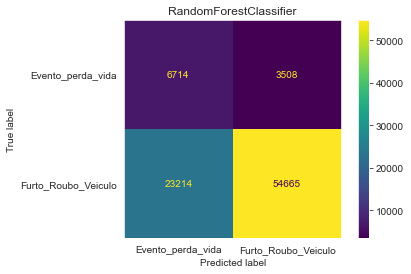

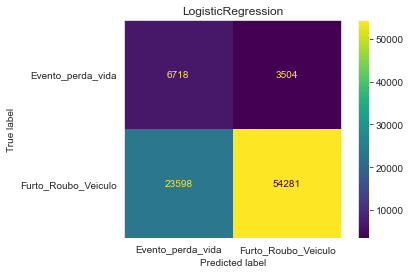

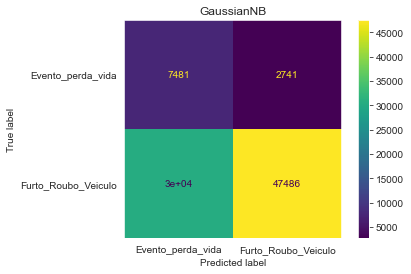

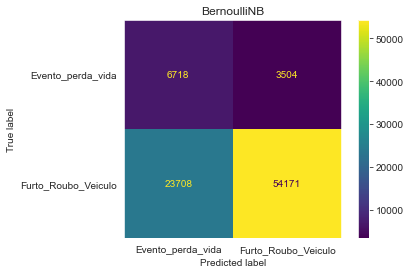

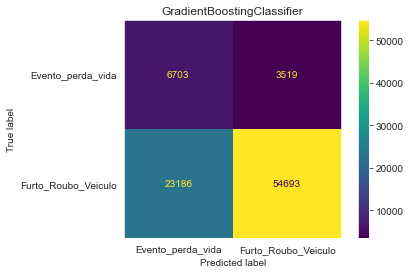

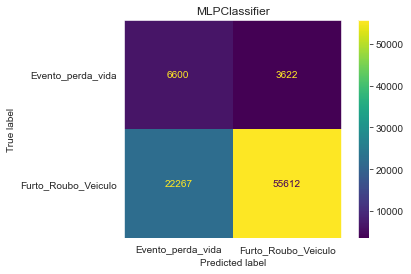

In [59]:
models_name_list = ['RandomForestClassifier','LogisticRegression','GaussianNB','BernoulliNB','GradientBoostingClassifier','MLPClassifier']
confusion_matrix_list = []
for i,model in enumerate(models_list):
    
    confusion_matrix_list.append(confusion_matrix(y_test,model.predict(X_test)))
    
    ConfusionMatrixDisplay(confusion_matrix(y_test,model.predict(X_test)),display_labels=['Evento_perda_vida', 'Furto_Roubo_Veiculo']).plot()
    plt.title(models_name_list[i])
    plt.grid(False)
    plt.show()

## Previsões (Centro de São Paulo Square 414/591)

### DIA/Dia de SEMANA/Sem Feriado

In [121]:
filtro_centro = (Models_Results['Square_ID']=='414.0')#'591.0' # '414.0'
filtro_dia = (Models_Results['HORA_PERIODO_ENCODED']==0)
filtro_semana = (Models_Results['DIA_SEMANA_ENCODED']==0)
filtro_feriado = (Models_Results['FERIADO_ENCODED']==0)

X_test_dia_semana_normal = X_test.loc[Models_Results.loc[filtro_centro & filtro_dia & filtro_semana & filtro_feriado].index]

for i,model in enumerate(models_list):
    print("MODELO: ",models_name_list[i])
    display(model.predict_proba(X_test_dia_semana_normal)[0])
    display(model.predict(X_test_dia_semana_normal)[0])

MODELO:  RandomForestClassifier


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


array([0.00930398, 0.99069602])

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


1

MODELO:  LogisticRegression


array([0.36515101, 0.63484899])

1

MODELO:  GaussianNB


array([0., 1.])

1

MODELO:  BernoulliNB


array([0.34244398, 0.65755602])

1

MODELO:  GradientBoostingClassifier


array([7.72691153e-04, 9.99227309e-01])

1

MODELO:  MLPClassifier


array([1.90088310e-04, 9.99809912e-01])

1

### DIA/Dia de SEMANA/Feriado

In [122]:
filtro_dia = (Models_Results['HORA_PERIODO_ENCODED']==0)
filtro_semana = (Models_Results['DIA_SEMANA_ENCODED']==0)
filtro_feriado = (Models_Results['FERIADO_ENCODED']==1)

X_test_dia_semana_normal = X_test.loc[Models_Results.loc[filtro_centro & filtro_dia & filtro_semana & filtro_feriado].index]

for i,model in enumerate(models_list):
    print("MODELO: ",models_name_list[i])
    display(model.predict_proba(X_test_dia_semana_normal)[0])

MODELO:  RandomForestClassifier


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


array([0.65, 0.35])

MODELO:  LogisticRegression


array([0.43835129, 0.56164871])

MODELO:  GaussianNB


array([0., 1.])

MODELO:  BernoulliNB


array([0.40443682, 0.59556318])

MODELO:  GradientBoostingClassifier


array([0.00146935, 0.99853065])

MODELO:  MLPClassifier


array([3.20781290e-09, 9.99999997e-01])

### NOITE/Dia de SEMANA/Sem Feriado

In [123]:
filtro_dia = (Models_Results['HORA_PERIODO_ENCODED']==1)
filtro_semana = (Models_Results['DIA_SEMANA_ENCODED']==0)
filtro_feriado = (Models_Results['FERIADO_ENCODED']==0)

X_test_dia_semana_normal = X_test.loc[Models_Results.loc[filtro_centro & filtro_dia & filtro_semana & filtro_feriado].index]

for i,model in enumerate(models_list):
    print("MODELO: ",models_name_list[i])
    display(model.predict_proba(X_test_dia_semana_normal)[0])

MODELO:  RandomForestClassifier


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


array([0.23962984, 0.76037016])

MODELO:  LogisticRegression


array([0.33788287, 0.66211713])

MODELO:  GaussianNB


array([0., 1.])

MODELO:  BernoulliNB


array([0.33380336, 0.66619664])

MODELO:  GradientBoostingClassifier


array([0.23394543, 0.76605457])

MODELO:  MLPClassifier


array([0.23161173, 0.76838827])

### NOITE/FDS/Sem Feriado

In [124]:
filtro_dia = (Models_Results['HORA_PERIODO_ENCODED']==1)
filtro_semana = (Models_Results['DIA_SEMANA_ENCODED']==1)
filtro_feriado = (Models_Results['FERIADO_ENCODED']==0)

X_test_dia_semana_normal = X_test.loc[Models_Results.loc[filtro_centro & filtro_dia & filtro_semana & filtro_feriado].index]

for i,model in enumerate(models_list):
    print("MODELO: ",models_name_list[i])
    display(model.predict_proba(X_test_dia_semana_normal)[0])

MODELO:  RandomForestClassifier


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


array([0.43340161, 0.56659839])

MODELO:  LogisticRegression


array([0.25755716, 0.74244284])

MODELO:  GaussianNB


array([0., 1.])

MODELO:  BernoulliNB


array([0.25288214, 0.74711786])

MODELO:  GradientBoostingClassifier


array([0.42879066, 0.57120934])

MODELO:  MLPClassifier


array([0.42228764, 0.57771236])

### NOITE/Dia de SEMANA/Feriado

In [92]:
filtro_dia = (Models_Results['HORA_PERIODO_ENCODED']==1)
filtro_semana = (Models_Results['DIA_SEMANA_ENCODED']==0)
filtro_feriado = (Models_Results['FERIADO_ENCODED']==1)

X_test_dia_semana_normal = X_test.loc[Models_Results.loc[filtro_centro & filtro_dia & filtro_semana & filtro_feriado].index]

for i,model in enumerate(models_list):
    print("MODELO: ",models_name_list[i])
    display(model.predict_proba(X_test_dia_semana_normal)[0])

In [120]:
Models_Results.join(RFC_Results_Prob)

,HORA_PERIODO_ENCODED,DIA_SEMANA_ENCODED,FERIADO_ENCODED,Square_ID,prob_E_P_VIDA_RFC,prob_VEICULO_RFC
6,1,0,0,491.0,0.37,0.63
17,1,1,0,591.0,0.10,0.90
21,1,0,0,500.0,0.66,0.34
48,1,0,0,417.0,0.27,0.73
51,1,1,1,480.0,0.31,0.69
...,...,...,...,...,...,...
469325,0,1,0,364.0,0.23,0.77
469337,0,1,0,557.0,0.30,0.70
469338,0,1,0,528.0,0.69,0.31
469341,0,1,0,517.0,0.21,0.79


In [93]:
Models_Results.join(RFC_Results_Prob).loc[Models_Results['Square_ID']=='414.0']
# Models_Results.join(RFC_Results_Prob).loc[Models_Results['Square_ID']=='470.0']

,HORA_PERIODO_ENCODED,DIA_SEMANA_ENCODED,FERIADO_ENCODED,Square_ID,prob_E_P_VIDA_RFC,prob_VEICULO_RFC
99,1,1,1,470.0,0.40,0.60
118,1,1,1,470.0,0.28,0.72
1022,0,1,0,470.0,0.41,0.59
1445,0,1,0,470.0,0.50,0.50
1467,0,1,0,470.0,0.24,0.76
...,...,...,...,...,...,...
465616,0,1,0,470.0,0.37,0.63
466698,0,1,0,470.0,0.20,0.80
467816,0,1,0,470.0,0.32,0.68
468094,1,1,0,470.0,0.10,0.90
